<a href="https://colab.research.google.com/github/ethan-dinh/BMS-225A/blob/main/bms225a_ds_workshop_3_student_notebook_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup

In [1]:
# install scanpy with additional dependences
# leiden for clustering, harmony for batch correction and skmisc which is needed for HVG selection
!pip install --quiet 'scanpy[leiden,harmony,skmisc]'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.3/169.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 83.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.6/183.6 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 81.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 101.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 6.4 MB/s eta 0:00:00


The following cell downloads the original data and creates the data files `/content/blood_RNA_raw_counts.h5ad` and `/content/blood_RNA_raw_counts_SCG12.h5ad` that we will use for our analysis.

In [2]:
# @title Download Data and create the **raw data** files that we will use for our analysis
################# THIS IS NOT PART OF THE WORKFLOW ##################
import os

if not os.path.exists('/content/blood_RNA.h5ad'):
  # downloading the data from the paper takes ~1min
  !wget -O blood_RNA.h5ad --header="User-Agent: Mozilla/5.0" "https://figshare.com/ndownloader/files/38849385?private_link=8aaa376913da23ae0def" > /dev/null 2>&1


if not os.path.exists('/content/blood_RNA_raw_counts.h5ad'):
  # -- create the raw data by removing all processed data information from the author's file
  import scanpy as sc
  # load the single cell RNA seq dataset from the h5ad file
  adata_processed = sc.read_h5ad('blood_RNA.h5ad') # AnnData object
  X_raw_counts = adata_processed.layers['counts']
  # the var dataframe
  raw_var_df = adata_processed.raw.var.copy()
  for i in raw_var_df.columns:
    del raw_var_df[i]
  raw_var_df['gene_name'] = raw_var_df.index
  # the obs dataframe
  raw_obs_df = adata_processed.obs[['LIBRARY',	'CoLabs_patient',	'condition']]
  raw_obs_df.columns = ['LIBRARY_ID', 'patient_id', 'condition']
  # create the anndata object
  adata = sc.AnnData(X = X_raw_counts, var=raw_var_df, obs=raw_obs_df)
  adata.write_h5ad('blood_RNA_raw_counts.h5ad')
  adata=adata[ adata.obs['LIBRARY_ID'] == 'XAUT1-POOL-SCG12']
  adata.write_h5ad('blood_RNA_raw_counts_SCG12.h5ad')
  del adata, adata_processed # delete the all data

/usr/local/lib/python3.12/dist-packages/scanpy/_utils/__init__.py:33: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/usr/local/lib/python3.12/dist-packages/scanpy/__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/usr/local/lib/python3.12/dist-packages/scanpy/readwrite.py:16: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):


# Single cell RNA seq analysis (single batch)
## Let's do a single batch first
The `'blood_RNA_raw_counts_SCG12.h5ad'` file only contains the single-cell data from a single sequencing batch (library):

LIBRARY_ID: `XAUT1-POOL-SCG12`.

In [3]:
import pandas as pd
import scanpy as sc

In [142]:
### Settings (optional) ###

# Show more columns in output
pd.set_option('display.max_columns', 50)

# Set parameters for the figures // sc.settings.set_figure_params?
sc.settings.set_figure_params(dpi=80,fontsize=16, facecolor="white",figsize=(8,6),color_map='viridis')

# Suppress all warnings -- not recommended when working on your research projects!
import warnings
warnings.filterwarnings("ignore")

# print out the package versions
print('scanpy version:', sc.__version__)
print('pandas version:', pd.__version__)

scanpy version: 1.11.4
pandas version: 2.2.2


## STEP 0: Load the data (raw counts)

In [232]:
###################################################### <- this will mark the functions that will change/update adata
# [🔺] load the AnnData object from the h5ad file (blood_RNA_raw_counts_SCG12)
adata = sc.read_h5ad('blood_RNA_raw_counts_SCG12.h5ad')

In [233]:
# display a summary of AnnData object
adata

AnnData object with n_obs × n_vars = 6410 × 22741
    obs: 'LIBRARY_ID', 'patient_id', 'condition'
    var: 'gene_name'

In [234]:
# [🔺] lets explore what is in adata. In the following two cells display the obs and var dataframes

In [235]:
# [🔺] obs
print(adata.obs)

                            LIBRARY_ID  patient_id condition
AAACCTGAGCTAAACA-1_2  XAUT1-POOL-SCG12   XAUT1-HS7      UCNB
AAACCTGAGTCAATAG-1_2  XAUT1-POOL-SCG12   XAUT1-HS2        HC
AAACCTGCAATGGAGC-1_2  XAUT1-POOL-SCG12   XAUT1-HS4        HC
AAACCTGCAGTAAGAT-1_2  XAUT1-POOL-SCG12   XAUT1-HS4        HC
AAACCTGCATTAACCG-1_2  XAUT1-POOL-SCG12   XAUT1-HS3        HC
...                                ...         ...       ...
TTTGTCAGTTGTACAC-1_2  XAUT1-POOL-SCG12   XAUT1-HS3        HC
TTTGTCATCCAAGCCG-1_2  XAUT1-POOL-SCG12  XAUT1-HS12       UCV
TTTGTCATCCACGTGG-1_2  XAUT1-POOL-SCG12   XAUT1-HS6      UCNB
TTTGTCATCCGATATG-1_2  XAUT1-POOL-SCG12   XAUT1-HS6      UCNB
TTTGTCATCTACTCAT-1_2  XAUT1-POOL-SCG12   XAUT1-HS6      UCNB

[6410 rows x 3 columns]


In [236]:
# [🔺] var
print(adata.var)

                   gene_name
RP11-34P13.7    RP11-34P13.7
RP11-34P13.15  RP11-34P13.15
RP11-34P13.16  RP11-34P13.16
RP11-34P13.13  RP11-34P13.13
FO538757.2        FO538757.2
...                      ...
RSPH1                  RSPH1
IMMTP1                IMMTP1
LINC00315          LINC00315
AL133493.2        AL133493.2
FTCD                    FTCD

[22741 rows x 1 columns]


In [237]:
# adata.var_names stores the gene names. It is the same as the index of the var dataframe:
adata.var_names

Index(['RP11-34P13.7', 'RP11-34P13.15', 'RP11-34P13.16', 'RP11-34P13.13',
       'FO538757.2', 'FO538757.1', 'AP006222.2', 'RP4-669L17.10',
       'RP4-669L17.8', 'RP5-857K21.4',
       ...
       'AJ006998.2', 'UBE3AP2', 'AP000569.9', 'AP000320.6', 'AP001619.2',
       'RSPH1', 'IMMTP1', 'LINC00315', 'AL133493.2', 'FTCD'],
      dtype='object', length=22741)

In [238]:
# You can also directly access adata.X
adata.X

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 5758880 stored elements and shape (6410, 22741)>

## STEP 1: Quality control

In [239]:
# mitochondrial gene names start with "MT-" for human and "Mt-" for mouse
# explain what the following command does (Hint: what is adata.var_names? what does the .str.startstwith() function do?)
adata.var_names.str.startswith("MT-")

array([False, False, False, ..., False, False, False])

In [240]:
######################################################
# [🔺] create a new column in adata.var dataframe that indicates if a gene is mitochondrial or not (True if it is / False otherwise)
# choose an informative name for the new column : )
adata.var['is_mitochondrial'] = adata.var_names.str.startswith("MT-")

In [241]:
# verify that the column was added (you can just display the relevant dataframe)
adata.var.head()

,gene_name,is_mitochondrial
RP11-34P13.7,RP11-34P13.7,False
RP11-34P13.15,RP11-34P13.15,False
RP11-34P13.16,RP11-34P13.16,False
RP11-34P13.13,RP11-34P13.13,False
FO538757.2,FO538757.2,False


In [242]:
# [🔺] pandas practice: select the var rows that correspond to mitochondrial genes.
# How many mitochondrial genes are in this dataset?
# Hint: adata.var is a dataframe and can be sliced as df[ condition based on a logical expression  ]
# Hint2: slice the var dataframe where the column you created above is equal to True

mito_genes = adata.var[adata.var['is_mitochondrial'] == True]
print(len(mito_genes))

28


In [243]:
# [🔹] for practice you can also add a column that indicates whether a gene is ribosomal
# ribosomal genes start with "RP" for human, "Rp" for mouse
adata.var['is_ribosomal'] = adata.var_names.str.startswith("RP-")

### Calculate QC metrics

In [244]:
adata # lets remind ourseleves about adata, the following command will add a lot of information

AnnData object with n_obs × n_vars = 6410 × 22741
    obs: 'LIBRARY_ID', 'patient_id', 'condition'
    var: 'gene_name', 'is_mitochondrial', 'is_ribosomal'

In [245]:
######################################################
# [🔺]use the sc.pp.calculate_qc_metrics() function to calculate qc metrics
# replace '????' with the column that indicated mitochondrial genes so that we also compute “% of counts in genes marked as mitochondrial”
# inplace=True --> updates the adata dataframe in place (adding all the qc columns)
# log1p=True --> calculates log1p tranformed versions (e.g., mean of logarithmized counts)

sc.pp.calculate_qc_metrics(adata, qc_vars=['is_mitochondrial'], inplace=True, log1p=True)

In [246]:
adata

AnnData object with n_obs × n_vars = 6410 × 22741
    obs: 'LIBRARY_ID', 'patient_id', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_is_mitochondrial', 'log1p_total_counts_is_mitochondrial', 'pct_counts_is_mitochondrial'
    var: 'gene_name', 'is_mitochondrial', 'is_ribosomal', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

### Filter genes

In [247]:
######################################################
# [🔺]filter genes that are expressed in fewer than 5 cells

sc.pp.filter_genes(adata, min_cells=5)

In [248]:
adata # notice that the number of genes decreased

AnnData object with n_obs × n_vars = 6410 × 17473
    obs: 'LIBRARY_ID', 'patient_id', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_is_mitochondrial', 'log1p_total_counts_is_mitochondrial', 'pct_counts_is_mitochondrial'
    var: 'gene_name', 'is_mitochondrial', 'is_ribosomal', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

### Visualize QC metrics (cells)

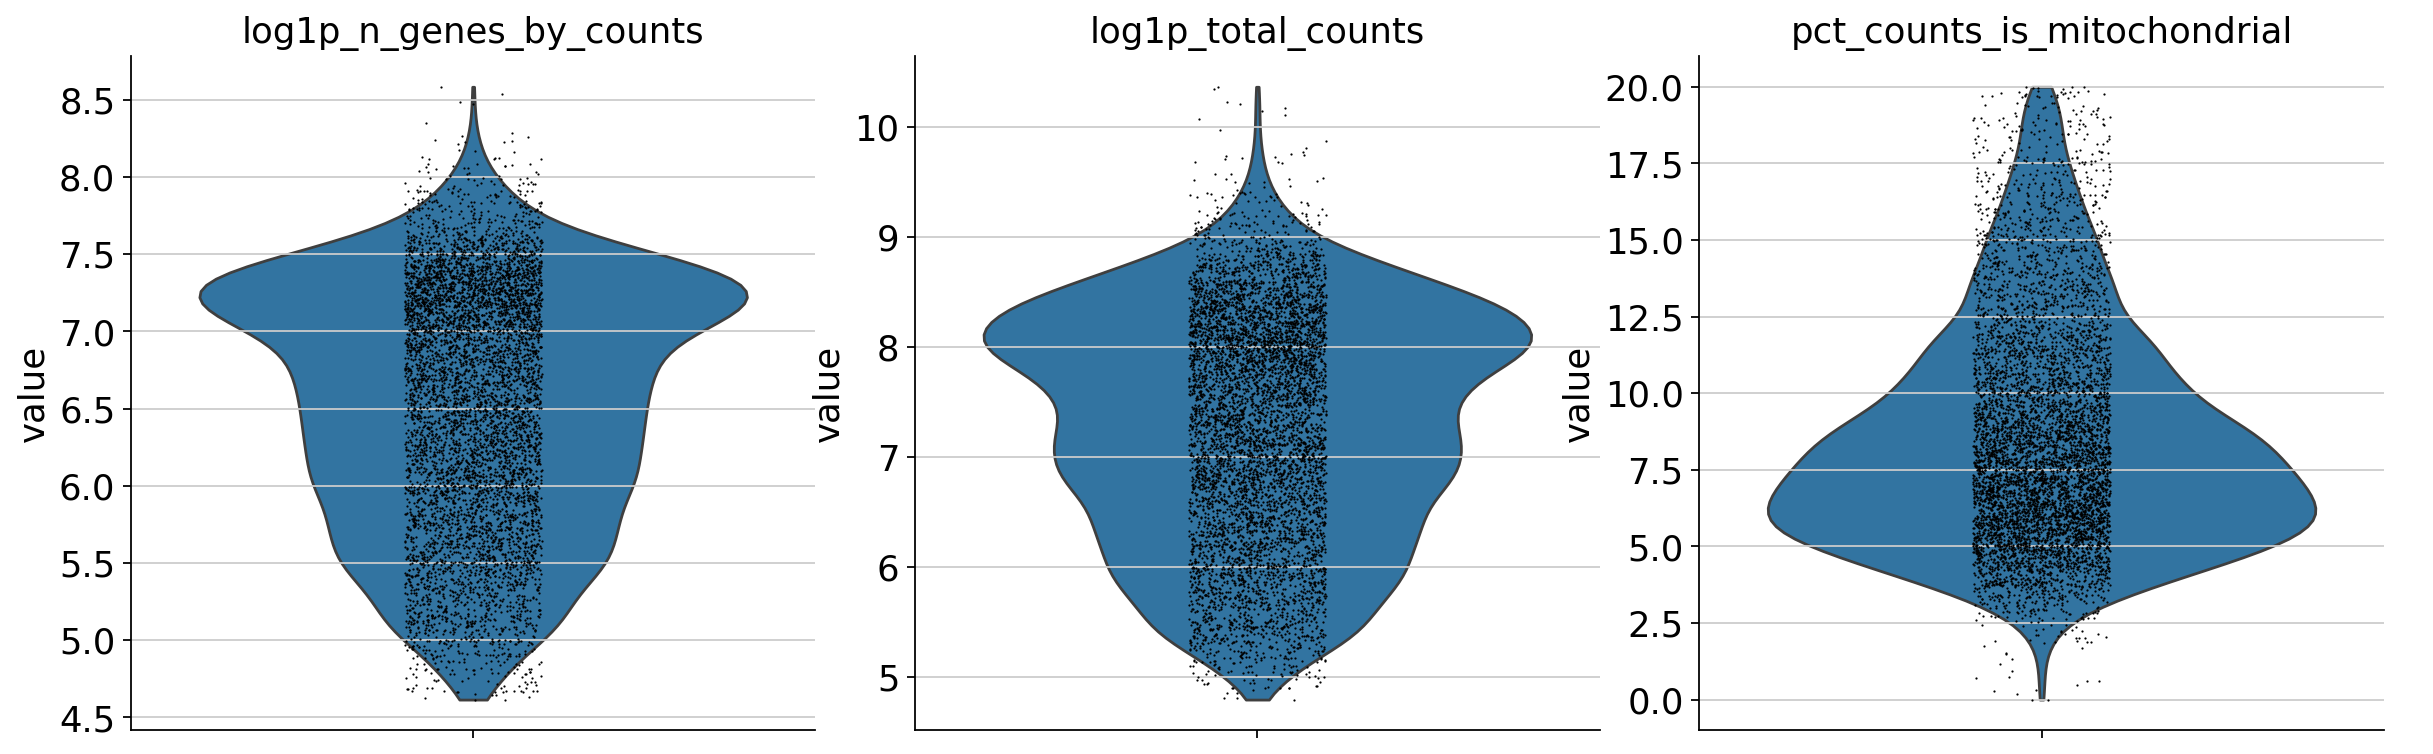

In [249]:
sc.pl.violin(
    adata,
    keys = ["log1p_n_genes_by_counts", "log1p_total_counts", "pct_counts_is_mitochondrial"],
    jitter=0.1,
    multi_panel=True,
    size=1
)

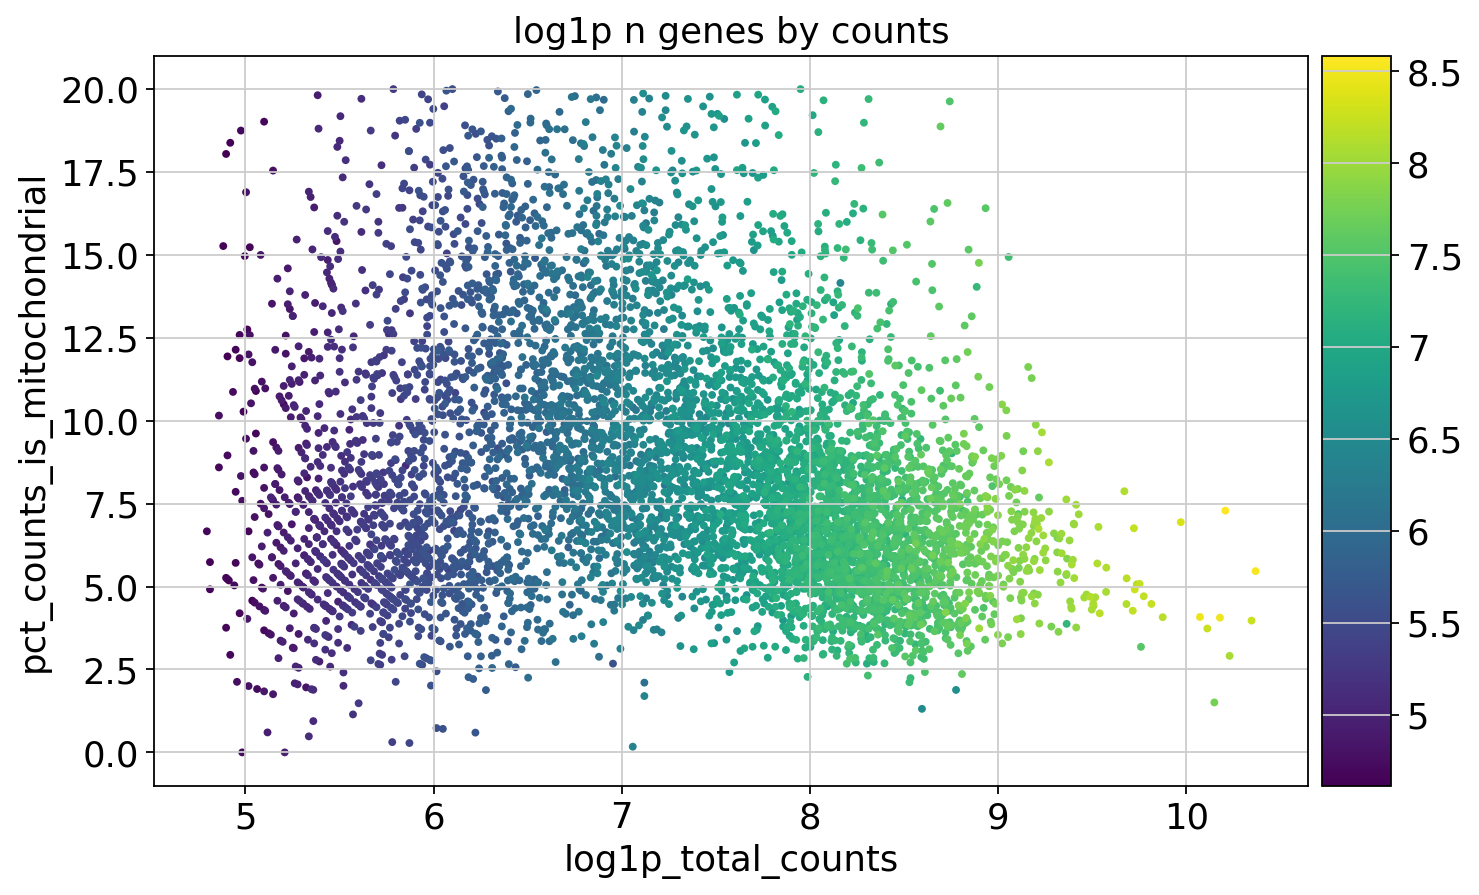

In [250]:
sc.pl.scatter(adata, "log1p_total_counts", "pct_counts_is_mitochondrial", color="log1p_n_genes_by_counts",size=50)

### Filter cells

In [197]:
# [🔺] pandas practice: How many cells have log1p_total_counts above 8?
print(len(adata[adata.obs['log1p_total_counts'] > 8]))

1946


In [251]:
##################################################
# [🔺] filter out cells by choosing QC thresholds for 'log1p_total_counts' and 'pct_counts_mt' based on the above plots
# ok to be lenient we can revisit this after clustering.

# Hint: AnnData can be sliced as a dataframe based on a condition (logical expression). E.g., df[df['age']>20]
# for AnnData the condition can be computed based on the obs dataframe: e.g., adata[ obs dataframe column is greater than 5 ]
# After slicing adata, don't forget to save the output back to adata: e.g. as we update a df variable df=df[df['age']>20].

adata = adata[
    (adata.obs['log1p_total_counts'] < 9) & (adata.obs['log1p_total_counts'] > 7) &
    (adata.obs['pct_counts_is_mitochondrial'] < 10)
  ]

In [252]:
adata # notice that the number of cells decreased

View of AnnData object with n_obs × n_vars = 2912 × 17473
    obs: 'LIBRARY_ID', 'patient_id', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_is_mitochondrial', 'log1p_total_counts_is_mitochondrial', 'pct_counts_is_mitochondrial'
    var: 'gene_name', 'is_mitochondrial', 'is_ribosomal', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

### Doublet detection (scrublet)

- We expect very few doublets in this particular case. The majority of doublets were removed using genetic information / patient SNPs.


In [174]:
#############################################
# doublet detection with scrublet
sc.pp.scrublet(adata)

In [175]:
adata # notice the columns 'doublet_score' and 'predicted_doublet' were added in obs. Also .uns appeared.

AnnData object with n_obs × n_vars = 6190 × 17473
    obs: 'LIBRARY_ID', 'patient_id', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_is_mitochondrial', 'log1p_total_counts_is_mitochondrial', 'pct_counts_is_mitochondrial', 'doublet_score', 'predicted_doublet'
    var: 'gene_name', 'is_mitochondrial', 'is_ribosomal', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'scrublet'

In [176]:
#### !!!
#### This is NOT part of the single cell analysis
#### we run this to create some (fake) detected doublets
#### because no doublets are actually detected in this sample
import numpy as np
adata.obs["predicted_doublet"] = np.random.rand(adata.n_obs) < 0.05

In [177]:
# .value_counts(): count how many times a value appears in a column of a dataframe
adata.obs['predicted_doublet'].value_counts()

,count
predicted_doublet,
False,5885
True,305


In [ ]:
##############################################
# [🔺] AnnData challenge: filter out detected doublets!
# Hint1: adata can be sliced as a DataFrame, i.e., adata[ some condition here ]
# Hint2: adata.obs has the predicted_doublet column which is False for the cells we want to keep



## STEP 2: Normalization and log-transformation

In [253]:
##############################################
# Before normalization, we want to save the count data to a new layer. The .copy() in the end makes sure that the data in adata.X are duplicated!!
# Otherwise the adata.layers["counts"] and adata.X will be pointing to the same location in computer memory
# which means that when one of them changes the other one does too. We don't want that : )

adata.layers["counts"] = adata.X.copy()

In [254]:
adata.layers["counts"].sum()

np.float64(10011352.0)

In [255]:
adata

AnnData object with n_obs × n_vars = 2912 × 17473
    obs: 'LIBRARY_ID', 'patient_id', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_is_mitochondrial', 'log1p_total_counts_is_mitochondrial', 'pct_counts_is_mitochondrial'
    var: 'gene_name', 'is_mitochondrial', 'is_ribosomal', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    layers: 'counts'

In [256]:
##############################################
# [🔺] Normalize data to 10K total counts

sc.pp.normalize_total(adata, target_sum = 10000)

- `target_sum = 10000` is kind of arbitrary but very widely used. If we don't specify the target_sum parameter, `sc.pp.normalize_total(adata)` by default will normalize to the median of the total counts.


In [257]:
# The only thing that changed is the X matrix (gene expression),
# which is now normalized to sum to 10K
adata.X.sum(1)

matrix([[10000.],
        [10000.],
        [10000.],
        ...,
        [10000.],
        [10000.],
        [10000.]])

In [258]:
##############################################
# [🔺] Logarithmize the data

sc.pp.log1p(adata)

In [259]:
adata.X.sum(1) # the X matrix changed. Each entry is now log(1+x)

matrix([[2206.50442962],
        [1608.12643059],
        [2252.01947841],
        ...,
        [2443.1480898 ],
        [1988.90255194],
        [2139.56974705]])

In [260]:
######################################################
# [🔺] save the log1p normalized counts to a new layer! Let's call it 'log1p'
# We want to keep these around (useful for plotting and differential expression analysis) and adata.X will change again later.

adata.layers['log1p'] = adata.X.copy()

## STEP 3: Highly variable genes (feature selection)

In [261]:
######################################################
sc.pp.highly_variable_genes(adata, n_top_genes = 2000,
                            flavor='seurat_v3',
                            layer='counts')

In [262]:
# This added information in the var dataframe
adata.var

,gene_name,is_mitochondrial,is_ribosomal,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,highly_variable,highly_variable_rank,means,variances,variances_norm
RP11-34P13.15,RP11-34P13.15,False,False,44,0.006864,0.006841,99.313573,44.0,3.806662,44,False,NaN,0.010646,0.010536,0.897665
RP11-34P13.13,RP11-34P13.13,False,False,46,0.007332,0.007306,99.282371,47.0,3.871201,46,False,NaN,0.008242,0.008864,0.979866
FO538757.1,FO538757.1,False,False,103,0.016381,0.016248,98.393136,105.0,4.663439,103,False,NaN,0.023695,0.023829,0.890745
AP006222.2,AP006222.2,False,False,5,0.000780,0.000780,99.921997,5.0,1.791759,5,False,NaN,0.001030,0.001030,0.987999
RP4-669L17.10,RP4-669L17.10,False,False,9,0.001404,0.001403,99.859594,9.0,2.302585,9,False,NaN,0.002747,0.002741,0.943215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AP001432.14,AP001432.14,False,False,5,0.000780,0.000780,99.921997,5.0,1.791759,5,False,NaN,0.001374,0.001372,0.979665
UMODL1-AS1,UMODL1-AS1,False,False,5,0.000780,0.000780,99.921997,5.0,1.791759,5,False,NaN,0.001030,0.001030,0.987999
AP001469.7,AP001469.7,False,False,5,0.000780,0.000780,99.921997,5.0,1.791759,5,False,NaN,0.000687,0.000687,0.994808
MT-TY,MT-TY,True,False,5,0.000780,0.000780,99.921997,5.0,1.791759,5,False,NaN,0.001374,0.001372,0.979665


In [216]:
# .sort_values(): sort a dataframe with respect to the values of a given column
# .head(10) prints the top 10
adata.var.sort_values('highly_variable_rank').head(10)

,gene_name,is_mitochondrial,is_ribosomal,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,highly_variable,highly_variable_rank,means,variances,variances_norm
PPBP,PPBP,False,False,218,0.205148,0.186603,96.599064,1315.0,7.182352,218,True,0.0,2.342817,1066.246719,17.811268
IGKV3-11,IGKV3-11,False,False,116,1.582839,0.948889,98.190328,10146.0,9.224933,116,True,1.0,1.105581,191.600564,13.319417
IGKV4-1,IGKV4-1,False,False,182,2.540562,1.264285,97.160686,16285.0,9.698061,182,True,2.0,6.680027,13738.118613,12.407661
HBB,HBB,False,False,1537,0.565835,0.448419,76.021841,3627.0,8.196437,1537,True,3.0,5.094042,1611.082772,12.269588
IGKV3-15,IGKV3-15,False,False,53,0.209984,0.190607,99.173167,1346.0,7.205635,53,True,4.0,1.121891,148.032670,11.024030
S100A8,S100A8,False,False,1960,8.689080,2.270999,69.422777,55697.0,10.927700,1960,True,5.0,33.765907,7676.029095,9.969007
IGLV2-23,IGLV2-23,False,False,26,0.095944,0.091616,99.594384,615.0,6.423247,26,True,6.0,0.496996,82.749617,9.234381
JCHAIN,JCHAIN,False,False,234,0.612793,0.477967,96.349454,3928.0,8.276140,234,True,7.0,1.221120,284.805629,9.008100
IGKV3-20,IGKV3-20,False,False,365,1.074727,0.729830,94.305772,6889.0,8.837826,365,True,8.0,1.169580,121.345962,8.602084
PTGDS,PTGDS,False,False,257,0.294072,0.257794,95.990640,1885.0,7.542213,257,True,9.0,1.376368,140.976342,8.231476


## STEP 4: Dimensionality reduction with PCA

In [263]:
adata # lets remind ourseleves about adata, the PCA will add a more information

AnnData object with n_obs × n_vars = 2912 × 17473
    obs: 'LIBRARY_ID', 'patient_id', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_is_mitochondrial', 'log1p_total_counts_is_mitochondrial', 'pct_counts_is_mitochondrial'
    var: 'gene_name', 'is_mitochondrial', 'is_ribosomal', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg'
    layers: 'counts', 'log1p'

In [264]:
#####################################################################
# Before PCA we typically scale features to unit variance (common step but not absolutely necessary)
# Note that this changes adata.X
sc.pp.scale(adata, zero_center=False) # we don't want to zero center.

In [265]:
#####################################################################
# PCA: by default this function uses only the highly variable genes
sc.tl.pca(adata, n_comps=50) # specify number of PCs (default is 50)

In [266]:
# notice that the .obsm appeared that holds representations of the cells (embeddings)
adata

AnnData object with n_obs × n_vars = 2912 × 17473
    obs: 'LIBRARY_ID', 'patient_id', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_is_mitochondrial', 'log1p_total_counts_is_mitochondrial', 'pct_counts_is_mitochondrial'
    var: 'gene_name', 'is_mitochondrial', 'is_ribosomal', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts', 'log1p'

In [267]:
# X_pca is a matrix of reduced dimensions (n_comps=50 in our case).
adata.obsm['X_pca'].shape

(2912, 50)

### Visualize PCA

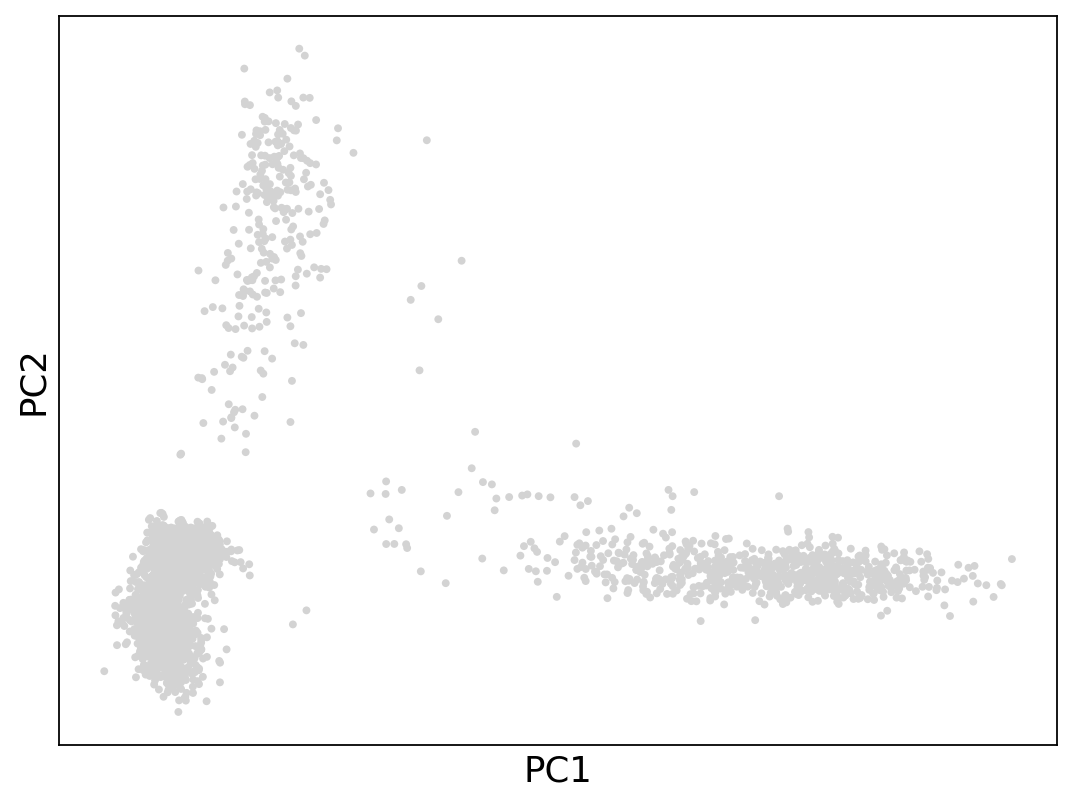

In [268]:
sc.pl.pca(adata,size=50)

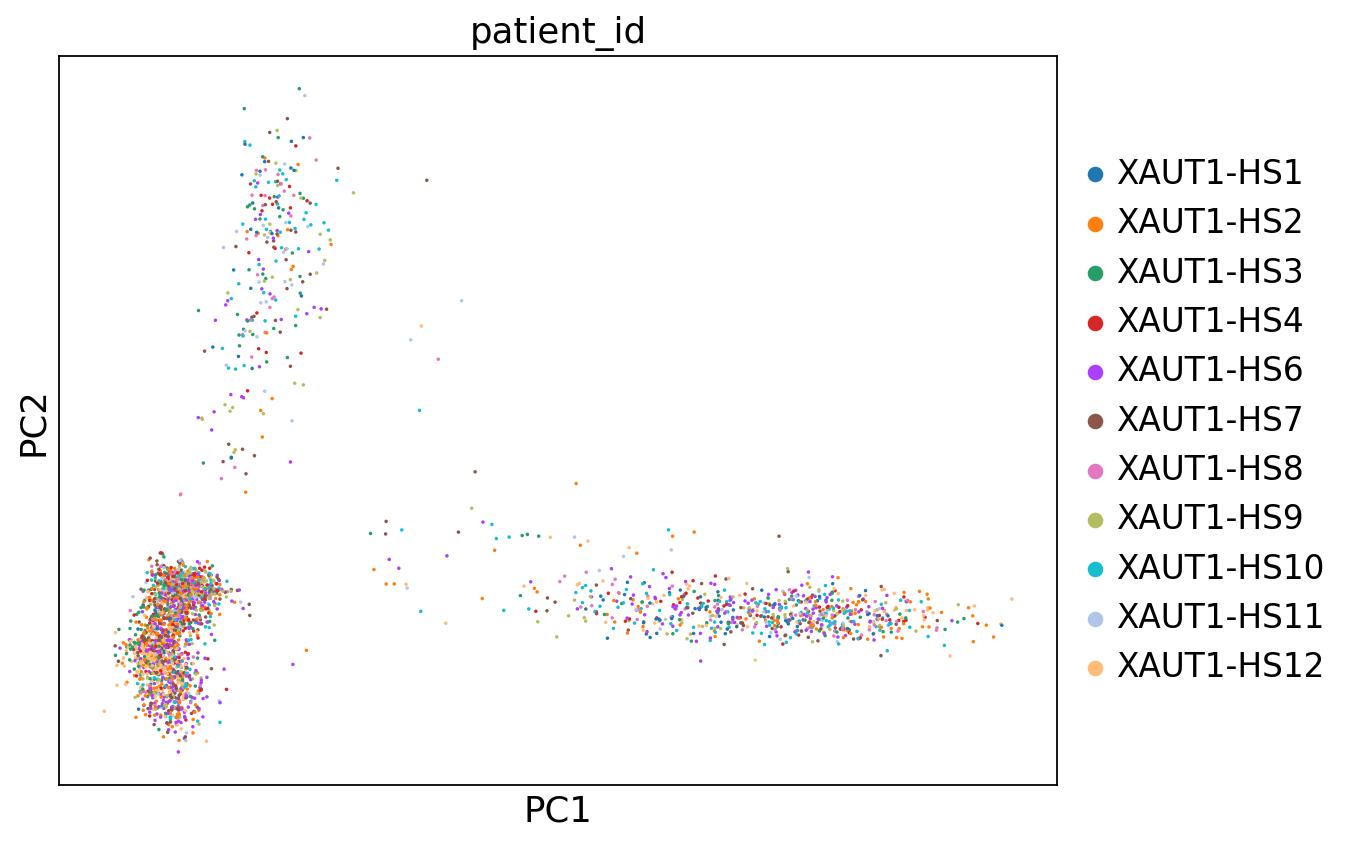

In [269]:
sc.pl.pca(adata,color='patient_id',size=10)

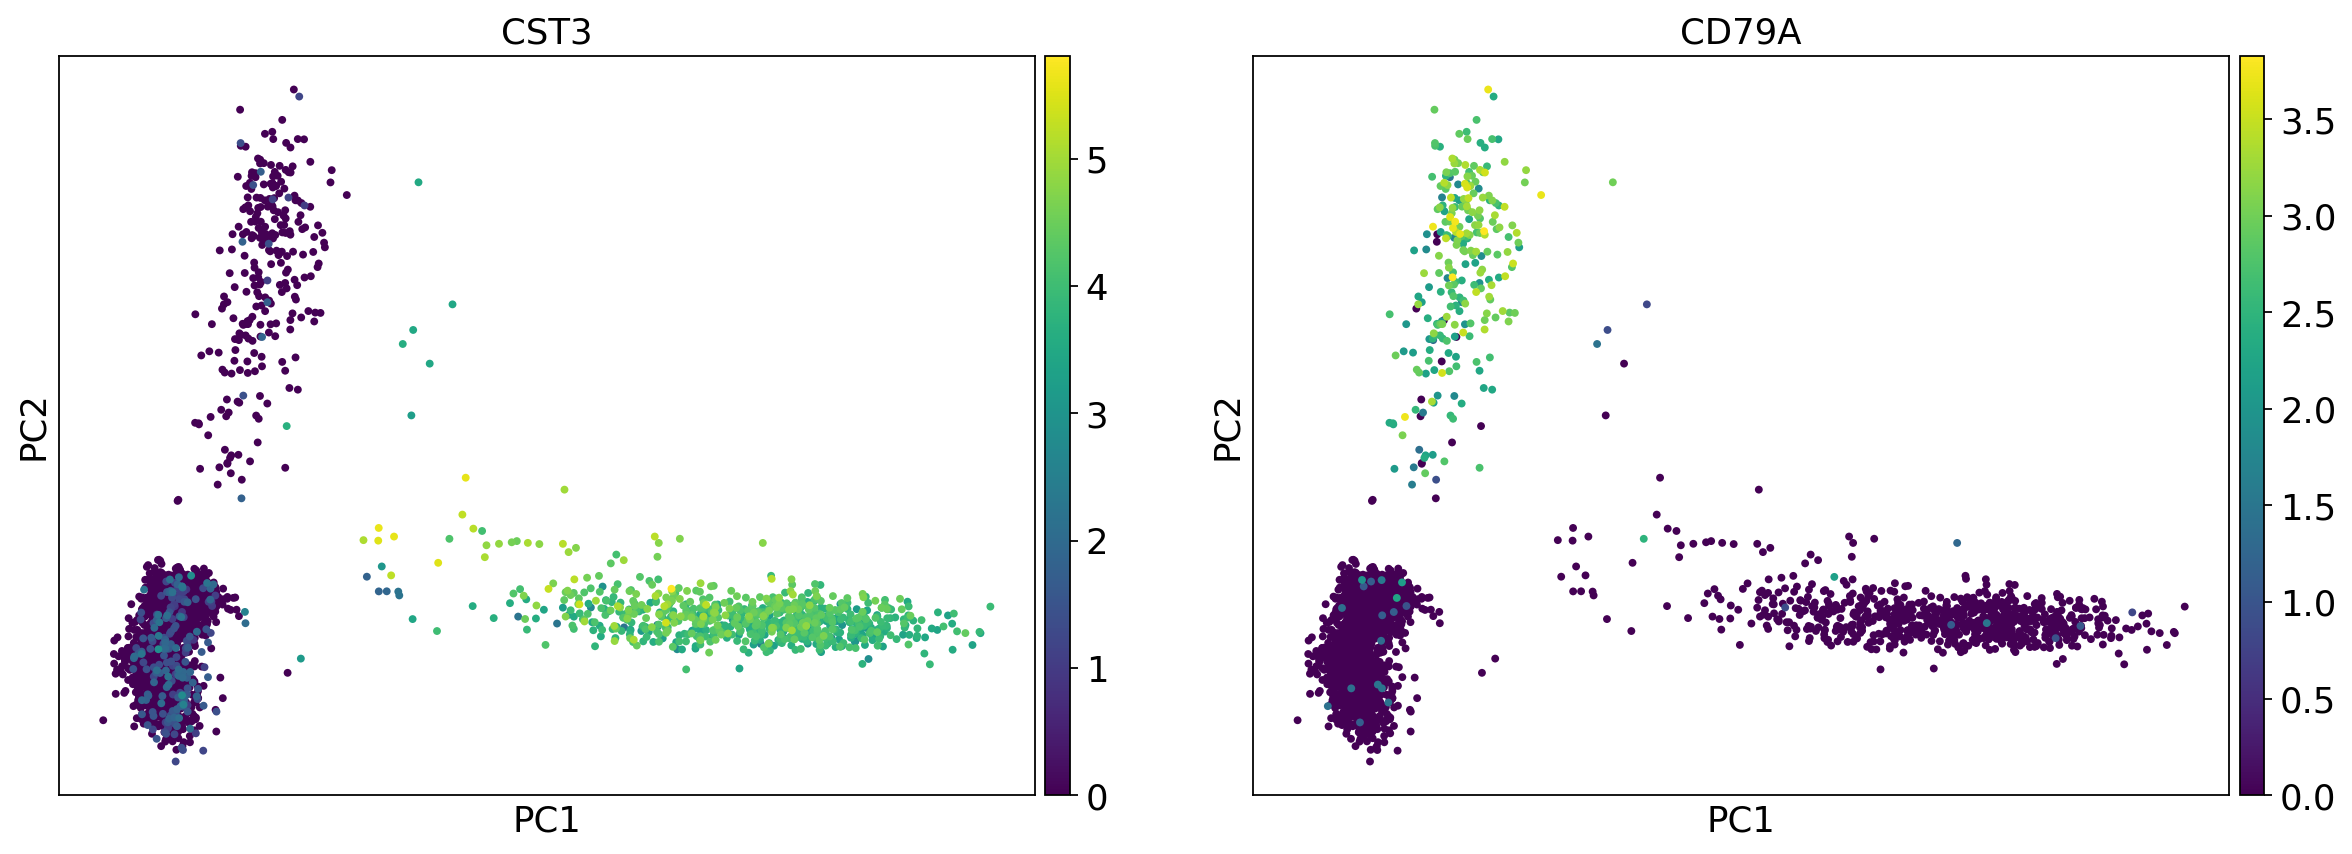

In [270]:
sc.pl.pca(adata,color=['CST3','CD79A'],size=50,layer='log1p')

## STEP 5: Nearest-neighbor graph, Clustering and UMAP projection

In [274]:
##############################################################
# [🔺] construct a k nearest neighbors graph (knn)
# 1. choose which representation to use
# 2. choose n_neighbors. Also specify random_state for reproducibility.

sc.pp.neighbors(adata, n_neighbors = 5, random_state = 42)

In [275]:
adata

AnnData object with n_obs × n_vars = 2912 × 17473
    obs: 'LIBRARY_ID', 'patient_id', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_is_mitochondrial', 'log1p_total_counts_is_mitochondrial', 'pct_counts_is_mitochondrial'
    var: 'gene_name', 'is_mitochondrial', 'is_ribosomal', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'patient_id_colors', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts', 'log1p'
    obsp: 'distances', 'connectivities'

In [276]:
##############################################################
# community detection algorithm that is used to cluster cells
# based on the neighbors graph we computed above.
# --> the key_added parameter defines the name of the obs column that will be added
#     this column will have the computed cluster label for each cell
# --> the resolution parameter specifies how coarse or fine-grained clusters will be

sc.tl.leiden(adata, resolution=1, key_added='leiden') # default parameters

In [277]:
adata

AnnData object with n_obs × n_vars = 2912 × 17473
    obs: 'LIBRARY_ID', 'patient_id', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_is_mitochondrial', 'log1p_total_counts_is_mitochondrial', 'pct_counts_is_mitochondrial', 'leiden'
    var: 'gene_name', 'is_mitochondrial', 'is_ribosomal', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'patient_id_colors', 'neighbors', 'leiden'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts', 'log1p'
    obsp: 'distances', 'connectivities'

In [278]:
##############################################################
# run umap on the neighbors graph we computed above
sc.tl.umap(adata, min_dist=0.5, spread=1.0) # default values for the two main parameters

In [279]:
adata

AnnData object with n_obs × n_vars = 2912 × 17473
    obs: 'LIBRARY_ID', 'patient_id', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_is_mitochondrial', 'log1p_total_counts_is_mitochondrial', 'pct_counts_is_mitochondrial', 'leiden'
    var: 'gene_name', 'is_mitochondrial', 'is_ribosomal', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'patient_id_colors', 'neighbors', 'leiden', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'log1p'
    obsp: 'distances', 'connectivities'

### Visualize UMAP

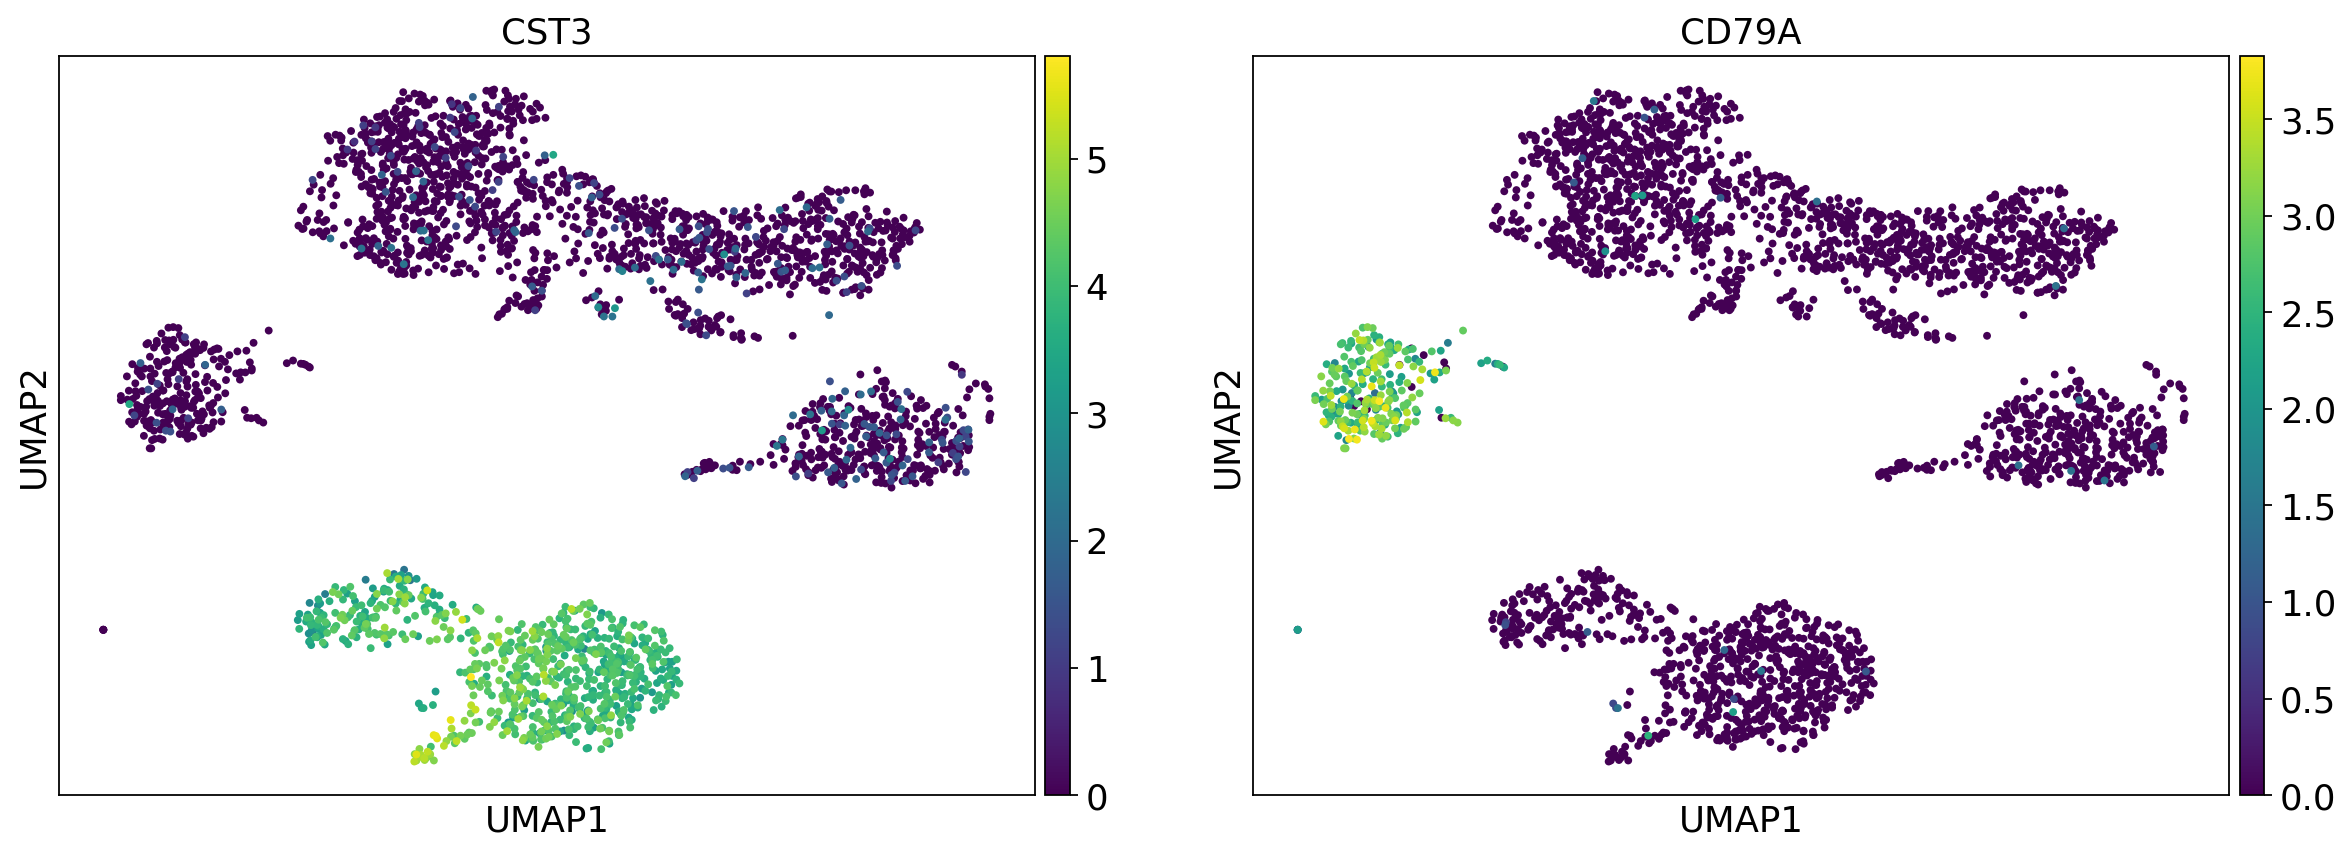

In [280]:
# the color parameter can be a list of genes. Gene expression is visualized from the specified layer
sc.pl.umap(adata,color=['CST3','CD79A'],size=50,layer='log1p')

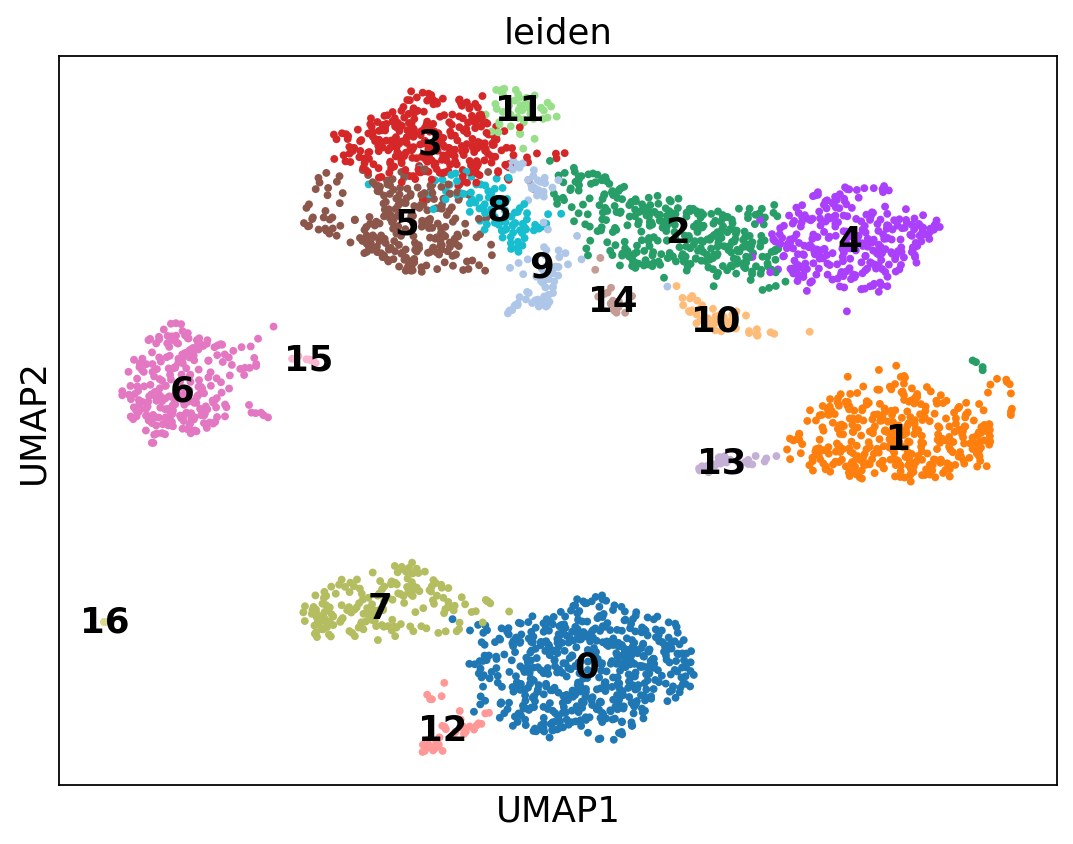

In [281]:
# the color parameter can also be categorical (e.g., below we specify the column from obs that holds the cluster labels we want)
sc.pl.umap(adata,color='leiden',size=50,legend_loc='on data')

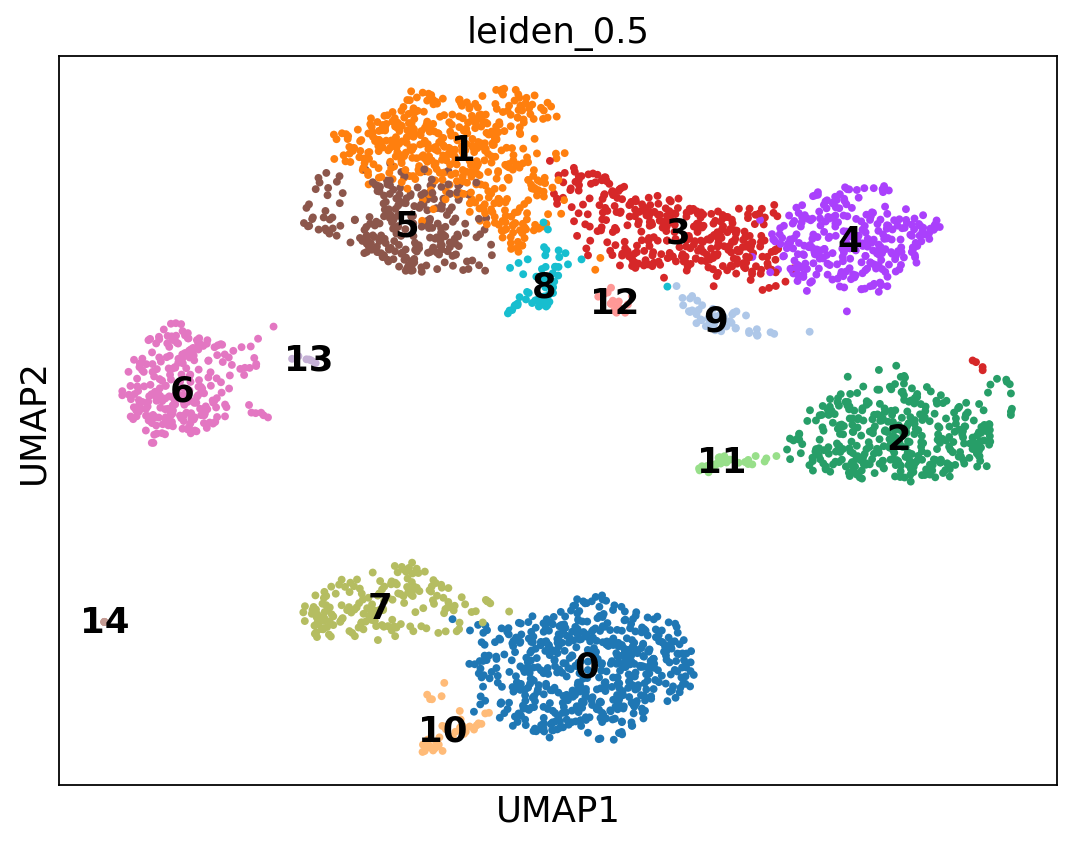

In [286]:
##############################################################
# [🔺] Cluster the cells at a lower resolution (e.g., resolution=0.5), and visualize again
# Important: Give a different name to the labels so that we don't overwrite the 'leiden' column in obs
# Hint: run the sc.tl.leiden function and then visualize with sc.pl.umap functions
# Note: you don't need to re-run the umap agorithm

sc.tl.leiden(adata, resolution=0.5, key_added='leiden_coarse')
sc.pl.umap(adata,color='leiden_0.5',size=50,legend_loc='on data')









In [287]:
# [🔹] Experiment with different neighbors, leiden and umap parameters

# lets work on a copy of the AnnData object for this
bdata = adata.copy() # anything we do with bdata won't affect adata

### pp.neighbors, tl.leiden, tl.umap and plot with pl.umap













## Differential expression analysis

In [288]:
##############################################################
sc.tl.rank_genes_groups(adata,
                        groupby='leiden_coarse',
                        method='wilcoxon',
                        layer='log1p')

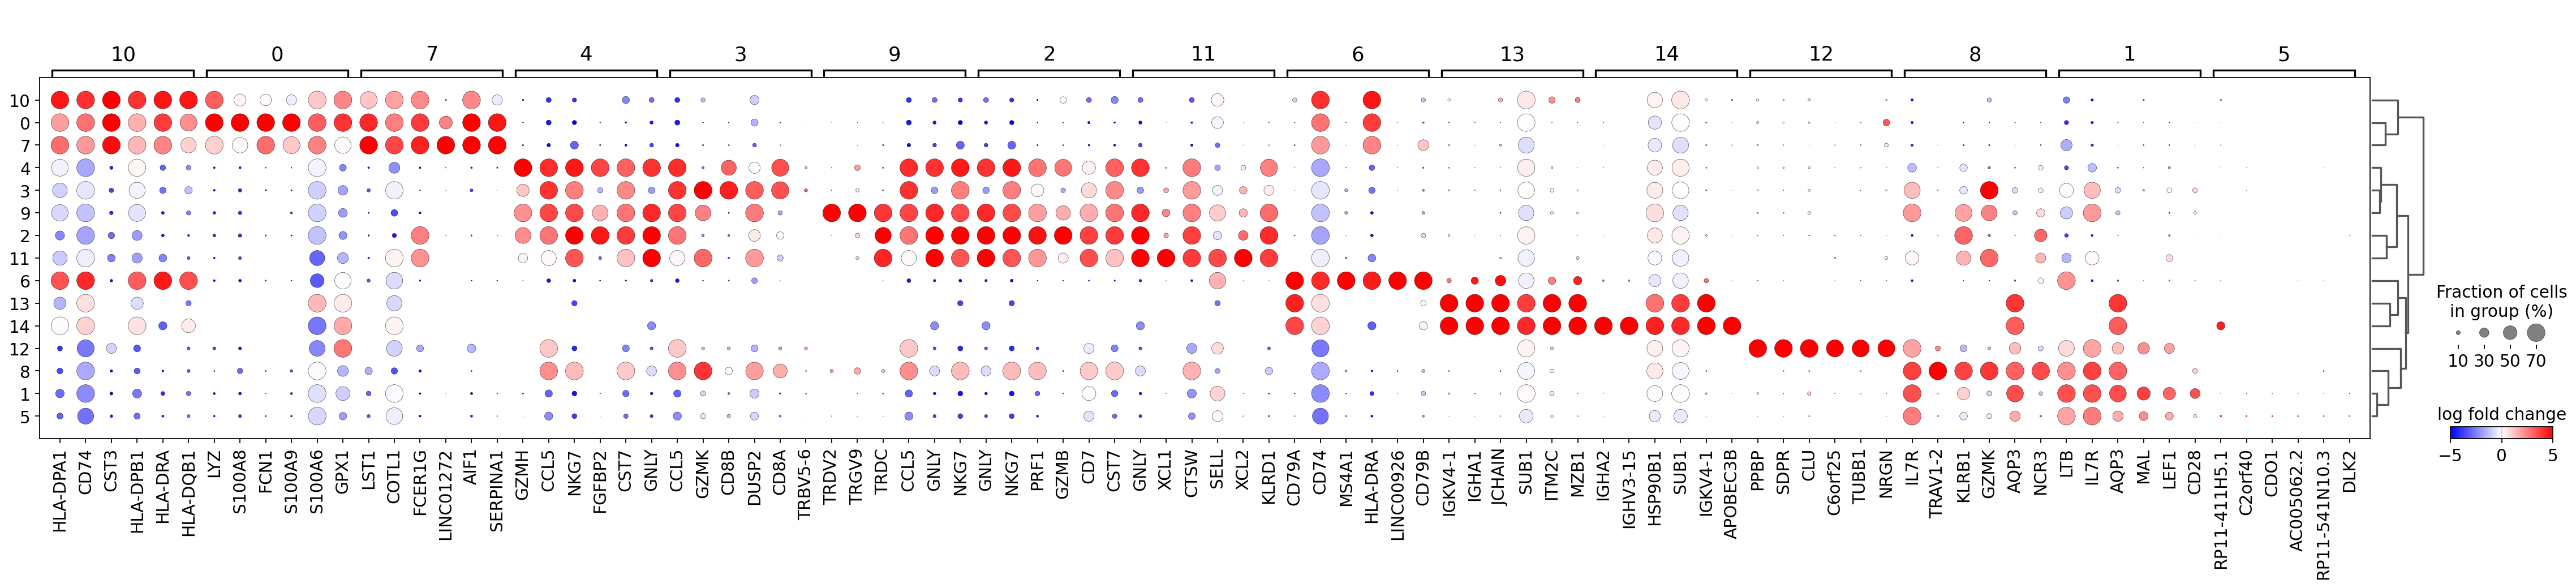

In [289]:
sc.pl.rank_genes_groups_dotplot(adata,
                                n_genes=6,
                                values_to_plot='logfoldchanges',
                                min_logfoldchange=3,
                                vmax=5,
                                vmin=-5,
                                cmap='bwr',
                                dot_max=0.7)


In [290]:
##############################################################
# [🔺] annotate the clusters!!

clusters_to_labels = {
    '0':'?',
    '1':'??',
    '2':'???',
    '3':'????'

}

# use the above dict to create a new column in obs with all cells labeled
# this is done by first mapping the cluster column to the values of the dict
# and assigning the result to a new column in obs
adata.obs['???'] = adata.obs['???'].map(clusters_to_labels)


## umap plot with the new labels
sc.pl.umap(adata,color='???',size=50,legend_loc='on data',legend_fontoutline=2,legend_fontsize=50)

KeyError: '???'

## STEP 6: Save the processed dataset

In [ ]:
adata.write_h5ad('blood_RNA_BMS225a_single_batch.h5ad') # this will be deleted when this session ends

In [ ]:
# [🔺] The h5ad file is too big to download so let's mount google drive from the Files tab and save it there
# adata.write_h5ad('/content/drive/MyDrive/your_project_folder/blood_RNA_BMS225a_single_batch.h5ad')

# Compact version of the analysis

In [ ]:
### [🔺] re-run all the commands that are necessary to get us from the raw data to the processed dataset
### For this compact version we can skip steps that print dataframes/ plot data / etc

new_data = sc.read_h5ad('blood_RNA_raw_counts_SCG12.h5ad')


#...


#...


#...


#...


#...


#...


#...


#...

### if everything is right we should be able to get the same umap as above
sc.pl.umap(new_data,...)

# DONE